In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle
from scipy.spatial import HalfspaceIntersection
from linear_gcs import GCSPlanner


In [ ]:
def draw_region(ax, hs, color):
    pts = hs.intersections
    c = pts.mean(axis=0)
    ang = np.arctan2(pts[:,1]-c[1], pts[:,0]-c[0])
    verts = pts[np.argsort(ang)]
    ax.add_patch(Polygon(verts, color=color, alpha=0.25))
    ax.plot(*verts.T, color=color, alpha=0.8)
    ax.plot([verts[0,0], verts[-1,0]],
            [verts[0,1], verts[-1,1]],
            color=color, alpha=0.8)

def rectangle_halfspace(xmin, xmax, ymin, ymax):
    hs = np.array([
        [ 1,  0, -xmax],
        [-1,  0,  xmin],
        [ 0,  1, -ymax],
        [ 0, -1,  ymin],
    ])
    center = np.array([(xmin+xmax)/2, (ymin+ymax)/2])
    return HalfspaceIntersection(hs, center)

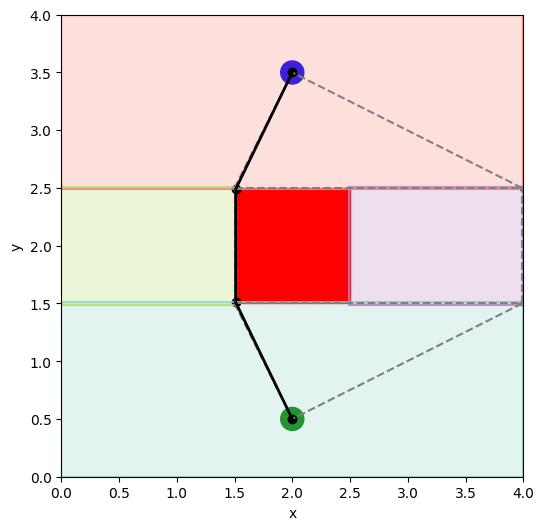

In [9]:
eps = 1e-2
square_regions = [
    rectangle_halfspace(0,   4, 0,    1.5 + eps),  # south
    rectangle_halfspace(0,   4, 2.5 - eps, 4),      # north
    rectangle_halfspace(0,   1.5 + eps, 1.5 - eps, 2.5 + eps),  # west
    rectangle_halfspace(2.5 - eps, 4, 1.5 - eps, 2.5 + eps),    # east
]

start        = np.array([2.0, 0.5])
goal         = np.array([2.0, 3.5])
world_bounds = np.array([[0, 4], [0, 4]])
obstacle     = np.array([[1.5,1.5],[2.5,1.5],[2.5,2.5],[1.5,2.5]])

planner = GCSPlanner(
    halfspace_regions=square_regions,
    start=start,
    goal=goal,
    world_bounds=world_bounds,
    solve_integer=False
)
shortest_path = planner.solve()  # returns list of 2D waypoints

plt.figure(figsize=(6,6))
ax = plt.gca()

# obstacle, start, goal
ax.add_patch(Polygon(obstacle, color='red'))
ax.add_patch(Circle(start, 0.1, color='green'))
ax.add_patch(Circle(goal,  0.1, color='blue'))

# draw the convex regions
cmap = plt.get_cmap("Set3")
for i, hs in enumerate(square_regions):
    draw_region(ax, hs, cmap(i/len(square_regions)))

# draw the conjugate graph (vertices + edges)
region_pts = planner.region_pts
conj       = planner.conjugate

ax.scatter(region_pts[:,0], region_pts[:,1], color="k", s=10)
for i in range(conj.shape[0]):
    for j in range(i, conj.shape[1]):
        if conj[i,j]:
            ax.plot(region_pts[[i,j],0],
                    region_pts[[i,j],1],
                    color="gray", linestyle="dashed")

# draw the rounded path
if shortest_path:
    sp = np.array(shortest_path)
    ax.plot(sp[:,0], sp[:,1], 'k-', lw=2)
    ax.scatter(sp[:,0], sp[:,1], color='k')

ax.set_aspect('equal')
plt.xlim(world_bounds[0])
plt.ylim(world_bounds[1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()
